## Imports

In [19]:
import sys
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

repo_dir = Path().resolve().parent
sys.path.append(str(repo_dir))
from pkg import models

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model definition

In [36]:
model_names = ['microsoft/resnet-18', 'Visual-Attention-Network/van-tiny']

model_name = model_names[1]

predictor = models.GlassProbaPredictor(model_name)

## Data inference example

In [27]:
def inference_on_images(predictor, images):
    probs = []
    inference_times = []

    for im in images:
        im = np.array(im)
        time1 = time.time_ns()
        prob = predictor.predict_proba(im)
        probs.append(prob)
        time2 = time.time_ns()
        inference_times.append((time2 - time1) / 10 ** 9)

    return probs, inference_times

In [34]:
data_dir = repo_dir / 'demo_data'
ims = [Image.open(im_fp).convert('RGB')
       for im_fp in data_dir.glob('*')]

Downloading:   0%|          | 0.00/69.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

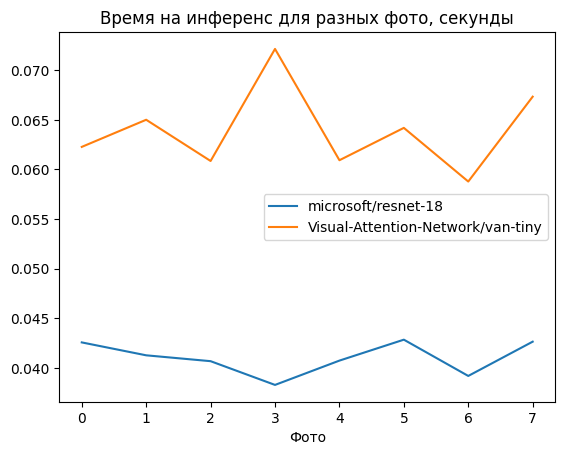

In [37]:
for model_name in model_names:
    predictor = models.GlassProbaPredictor(model_name)
    probs, inference_times = inference_on_images(predictor, ims)

    plt.plot(inference_times, label=model_name)
    plt.xlabel('Фото')
    plt.title('Время на инференс для разных фото, секунды')

plt.legend();

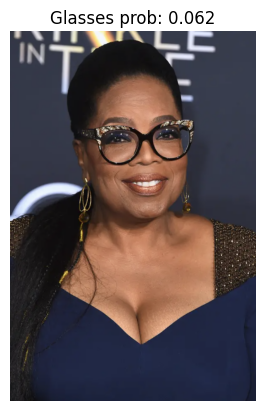

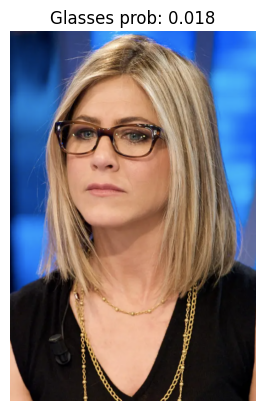

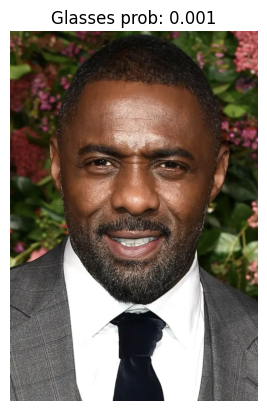

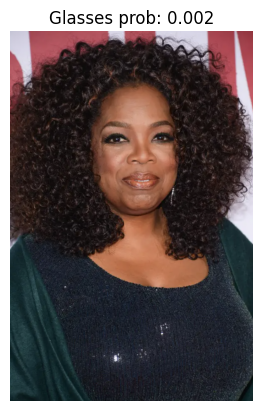

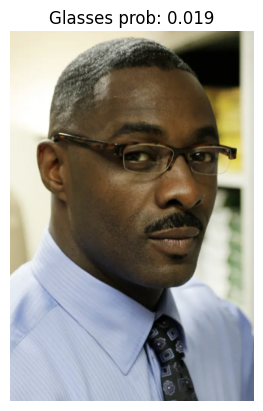

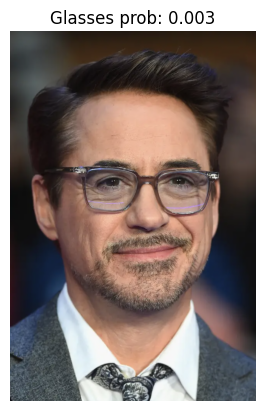

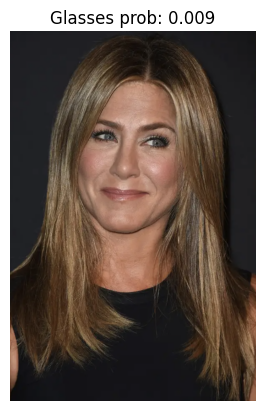

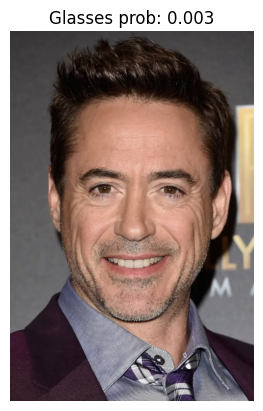

In [32]:
for im, prob in zip(ims, probs):

    im = np.array(im)
    plt.imshow(im)
    plt.axis('off')
    plt.title(f'Glasses prob: {prob:.3f}')
    plt.show()

In [ ]:
?